In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *

%matplotlib inline
sns.set()

C:\Users\Sam\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\Users\Sam\Anaconda3\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
C:\Users\Sam\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [32]:
#grab specific columns of interest
fields = ['decday', 'Mdate', 'datetime', 'wm_gf', 'wm', 'gpp_ANNnight', 'wq_gf', 'TA.y', 'sal', 'PAR', 'VPD', 'PA.x', 
         'PRECIP', 'ustar', 'WT', 'H_gf', 'TW_WATER_10cm']

# import dataset
peat6 = pd.read_csv('data/peat6_all.csv', usecols=fields)
peat6.datetime = pd.to_datetime(peat6.datetime) #convert datetime to correct type
peat6.dtypes

decday                  float64
Mdate                   float64
PA.x                    float64
ustar                   float64
wm                      float64
H_gf                    float64
wq_gf                   float64
wm_gf                   float64
gpp_ANNnight            float64
TA.y                    float64
PRECIP                  float64
PAR                     float64
WT                      float64
TW_WATER_10cm           float64
VPD                     float64
datetime         datetime64[ns]
sal                     float64
dtype: object

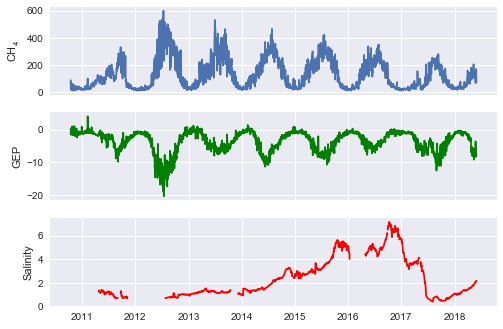

In [62]:
#aggregate to daily cumulative fluxes and mean environmental conditions
peat6['dday'] = peat6['decday'] // 1

daily = pd.DataFrame(peat6.groupby('dday')['wm_gf'].agg('mean')) * 12.01 * 3600 * 24 / 1E6
daily.columns = ['CH4']
daily['GEP'] = peat6.groupby('dday')['gpp_ANNnight'].agg('mean') * 12.01 * 3600 * 24 / 1E6
daily['Sal'] = peat6.groupby('dday')['sal'].agg('mean')
daily['Ta'] = peat6.groupby('dday')['TA.y'].agg('mean')
daily['datetime'] = peat6.groupby('dday')['datetime'].agg('min')

#plot daily fluxes of CH4, GEP, and mean salinity
fig, ax = plt.subplots(3, sharex='col')

ax[0].plot(daily['datetime'], daily['CH4'])
ax[0].set_ylabel('$\mathregular{CH_{4}}$')
ax[1].plot(daily['datetime'], daily['GEP'], color='green')
ax[1].set_ylabel('GEP')
ax[2].plot(daily['datetime'], daily['Sal'], color='red')
ax[2].set_ylabel('Salinity')

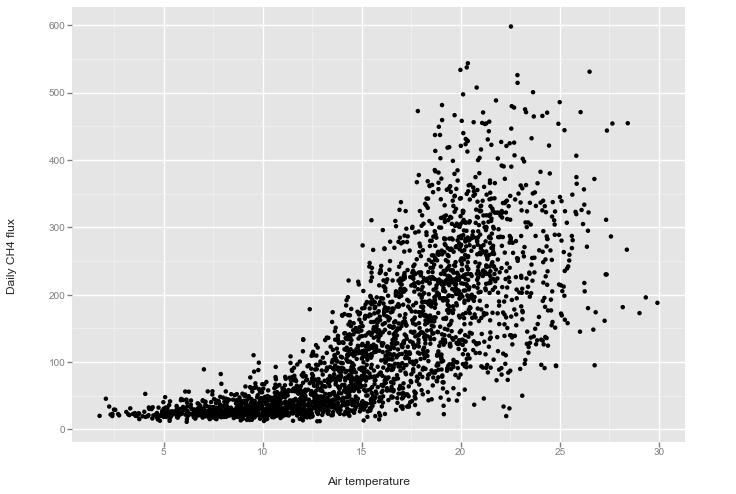

<ggplot: (-9223371845588160722)>

In [65]:
ggplot(daily, aes(x='Ta', y='CH4')) +\
    geom_point() +\
    xlab('Air temperature') + ylab('Daily CH4 flux')